# An end-to-end project in Machine Learning

## Using machine learning to predict bike rentals

### October 4, 2021 by Mauricio A Álvarez (edited, David Wong 2022)

Our dataset comes from a popular machine learning repository that hosts open source datasets for educational and research purposes, the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). We are going to follow several of the steps in the ML project checklist and use several utilities and models in [scikit-learn](https://scikit-learn.org/stable/) for predicting bike rentals. The description of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand#).

The broad idea is to predict the number of rental bikes required at a given hour of the data, given additional information about the weather. As we are predicting a continuous outcome, this is a *regression* (rather than classification) task.

### Get the data

In [1]:
import urllib.request
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv', './SeoulBikeData.csv')

('./SeoulBikeData.csv', <http.client.HTTPMessage at 0x1e013105dc0>)

In [2]:
import pandas as pd 
bike_sharing_data = pd.read_csv('SeoulBikeData.csv', encoding= 'unicode_escape')

We can get a description of the data

In [3]:
bike_sharing_data.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


We can see some of the rows in the dataset 

In [4]:
bike_sharing_data.sample(5)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
4869,21/06/2018,2436,21,23.8,63,1.5,1455,16.3,0.00,0.0,0.0,Summer,No Holiday,Yes
1020,12/01/2018,178,12,-9.6,27,2.0,1945,-25.1,1.17,0.0,0.0,Winter,No Holiday,Yes
6663,04/09/2018,1178,15,26.7,51,3.4,2000,15.7,2.09,0.0,0.0,Autumn,No Holiday,Yes
618,26/12/2017,481,18,-4.7,23,3.4,2000,-22.7,0.01,0.0,0.0,Winter,No Holiday,Yes
4408,02/06/2018,1707,16,29.6,26,3.7,2000,8.0,2.58,0.0,0.0,Summer,No Holiday,Yes


The target variable $y$ corresponds to the Rented Bike Count variable of the second column. The following columns correspond to the variables in the feature vector $\mathbf{x}$, *e.g.*, *Hour* is $x_1$ up until *Functioning Day* which is $x_D$. The original dataset also has a date column that we are not going to use in this notebook.

In [5]:
bike_sharing_data = bike_sharing_data.drop('Date', axis=1)

We follow some of the steps in the ML checklist we used in the lecture, including data exploration, data preprocessing, and fine-tuning (hyperparameter tuning) the ML model. It is important to remember that the testing data that we use for assessing the generalisation performance has to be set aside once we get the data. Also, any data preprocessing that you do has to be done only on the training data and several quantities need to be saved for the test stage. Separating the dataset into training and test before any preprocessing has happened, help us to recreate the real world scenario where we will deploy our system and for which the data will come without any preprocessing.

We use scikit-learn to separate the data into training and test sets. Let us first look at how many instances we have in the dataset

In [6]:
bike_sharing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8760 non-null   int64  
 1   Hour                       8760 non-null   int64  
 2   Temperature(°C)            8760 non-null   float64
 3   Humidity(%)                8760 non-null   int64  
 4   Wind speed (m/s)           8760 non-null   float64
 5   Visibility (10m)           8760 non-null   int64  
 6   Dew point temperature(°C)  8760 non-null   float64
 7   Solar Radiation (MJ/m2)    8760 non-null   float64
 8   Rainfall(mm)               8760 non-null   float64
 9   Snowfall (cm)              8760 non-null   float64
 10  Seasons                    8760 non-null   object 
 11  Holiday                    8760 non-null   object 
 12  Functioning Day            8760 non-null   object 
dtypes: float64(6), int64(4), object(3)
memory usage:

Note that there are 8760 entries, and each feature variable has 8760 non-null entries. In other words, there is no missing data.

Several algorithms that we will use assume the inputs to be type 'float' instead of 'int', so we transform those variables in the dataset from int64 to float64. If you have not previously come across the idea of a floating point / integer data type, please refer to Python documentation.

In [7]:
for col in ['Rented Bike Count', 'Hour', 'Humidity(%)', 'Visibility (10m)']:
    bike_sharing_data[col] = bike_sharing_data[col].astype('float64')

In [8]:
bike_sharing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8760 non-null   float64
 1   Hour                       8760 non-null   float64
 2   Temperature(°C)            8760 non-null   float64
 3   Humidity(%)                8760 non-null   float64
 4   Wind speed (m/s)           8760 non-null   float64
 5   Visibility (10m)           8760 non-null   float64
 6   Dew point temperature(°C)  8760 non-null   float64
 7   Solar Radiation (MJ/m2)    8760 non-null   float64
 8   Rainfall(mm)               8760 non-null   float64
 9   Snowfall (cm)              8760 non-null   float64
 10  Seasons                    8760 non-null   object 
 11  Holiday                    8760 non-null   object 
 12  Functioning Day            8760 non-null   object 
dtypes: float64(10), object(3)
memory usage: 889.8+ K

The dataset has a few thousand observations. We will use 85% of the data for training and 15% for testing. The `train_test_split` function in scikit-learn allows to easily get these partitions.

In [9]:
from sklearn.model_selection import train_test_split
bs_train_set, bs_test_set = train_test_split(bike_sharing_data, test_size=0.15, random_state=42)

The train and test sets are chosen randomly from all the available data. By specifying a value for `random_state`, we are making sure that every time we run this instruction, the train and test set will have the exact same instances. `random_state` "controls the shuffling applied to the data before applying the split". 

### Explore the data

There are different tools we can use to explore the dataset. 

#### Histograms

Let us first look at histograms for each of the continuous attributes.

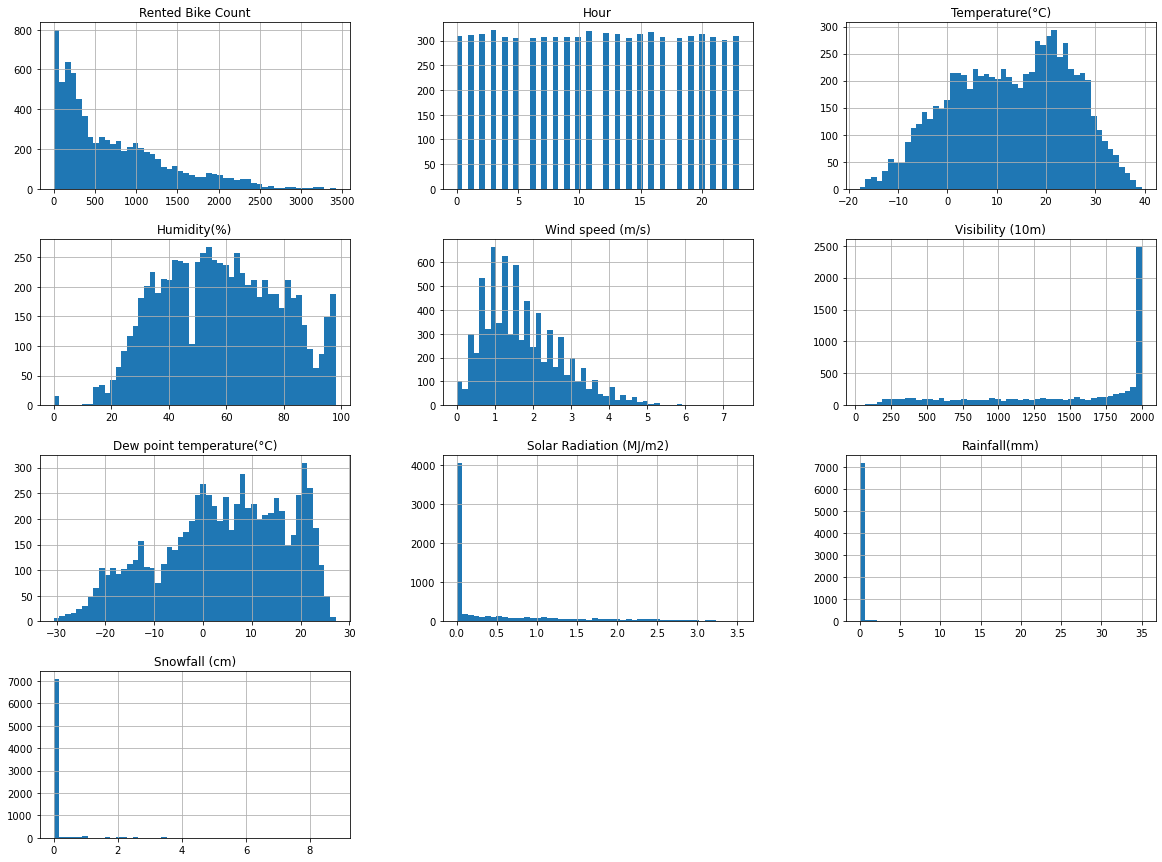

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt
bs_train_set.hist(bins=50, figsize=(20,15))
plt.show()

Some observations from the histograms are:

1. The values for the variables Rainfall, Snowfall, Solar Radition and Visibility are concentrated at one of the ends of the plots. This is an indication that several instances might contain outliers. One can consider removing these outliers from the data or binning the data into a few discrete values. 

2. Both the Rented Bike Count and the Wind Speed are [skewed to the right](https://en.wikipedia.org/wiki/Skewness), this is, the mean of the distribution is to the right of the median. Some ML algorithms find it harder to detect patterns for this type of distribution. One might consider transforming these features using $\log(x)$ or $\sqrt{x}$ so that they look more like a bell-shaped distribution. 

#### Question 1

1. Compute the mean and the median for the variables Rented Bike Count and Wind Speed and verify that the mean is to the right of the median.

2. How would the histograms for Rented Bike Count and the Wind Speed look like if we transform the values using $\sqrt{x}$? 

3. Would it be possible to use $\log{x}$ instead of $\sqrt{x}$? If not, what would you do to the variable to be able to use it?

In [ ]:
#Provide your answer here

#### Scatter plots

The Scatter plot is a tool we can use to explore dependencies between the different variables. It contains plots of each variable against each other in the dataset. If there are many variables in the feature vector, including all scatter plots might not be convenient to visualise. Let us look at the scatter plot for the target variable and four of the attributes. 

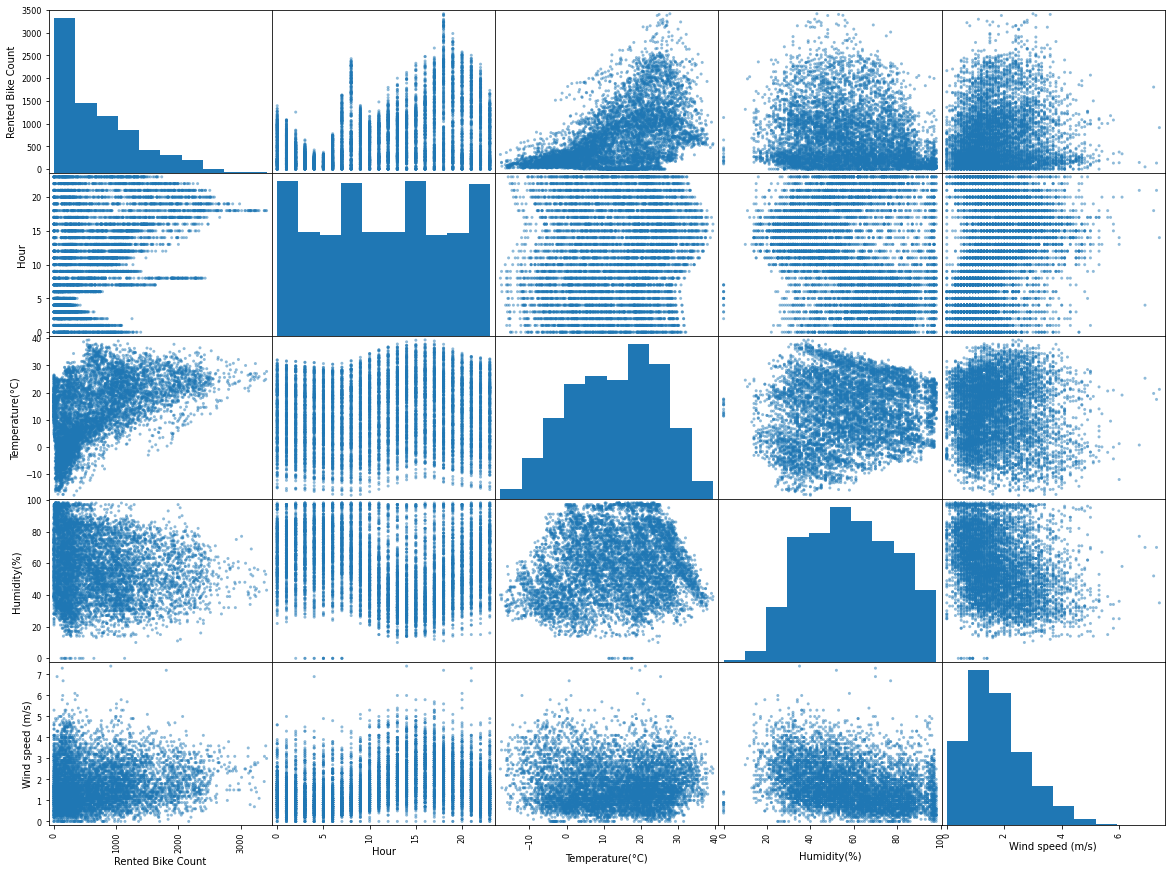

In [12]:
from pandas.plotting import scatter_matrix
attributes = ['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)']
figscat = scatter_matrix(bs_train_set[attributes], figsize=(20, 15))

The variables Hour and Temperature seem well correlatd with Rented Bike Count. The relationship between Humidity and Wind Speed with Rented Bike Count looks less clear though.

### Correlation coefficients

Additionally, we can study the correlation coefficient between the numerical attributes and the Rented Bike Count.

In [13]:
corr_matrix = bs_train_set.corr()
corr_matrix['Rented Bike Count'].sort_values(ascending=False)

Rented Bike Count            1.000000
Temperature(°C)              0.537556
Hour                         0.417382
Dew point temperature(°C)    0.379268
Solar Radiation (MJ/m2)      0.256920
Visibility (10m)             0.203152
Wind speed (m/s)             0.116280
Rainfall(mm)                -0.124748
Snowfall (cm)               -0.142316
Humidity(%)                 -0.198830
Name: Rented Bike Count, dtype: float64

As we suspected by having looked at the scatter plots, Temperature and Hour are strongly correlated with the target value. 

#### Question 2

What would be the correlation coefficients if the variables Rented Bike Count and Wind Speed are transformed using $\sqrt{x}$? 

In [ ]:
# Provide your answer here

### Prepare the data

We will now prepare the data so that it is suitable for the machine learning models. We consider the following processes for the dataset in this notebook: using one-hot-encoding for the categorical attributes and feature scaling for the numerical attributes. scikit-learn provides utilities for these tasks:

1. [OneHotEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=onehotencoder#sklearn.preprocessing.OneHotEncoder) allows to transform a categorical variable to a one-hot encoding representation. 

2. [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) performs feature scaling by standardisation.

`OneHotEncoder()` and `StandardScaler()` are part of the scikit-learn [preprocessing module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing). 

#### Question 3

Explore the scikit-learn [preprocessing module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing). List and explain two of the utilities availaible that you believe are useful for data analysis.

*Provide your answer here*

`OneHotEncoder()` and `StandardScaler()` are examples of [data transformations](https://scikit-learn.org/stable/data_transforms.html). In scikit-learn these are referred to as *transformers* and they map the data from one format to another. In a programming context, transformers are classes. They come with the following methods:

- `fit` that is used to learn the  transformation from data. 
- `transform` that is used to transform the data once the transformer has been fitted.   
- `fit_transform` that applies first `fit` and then `transform` to the data.

Typically, we use either `fit` or `fit_transform` for the training data and `transform` for the validation or test data.

Since the one-hot-encoding and standardisation transformations will be applied to different columns in the dataset, it is convenient to have a function that applies them both. It is particulaly useful since we need to apply those transformations to the train, validation and test sets. We could code such function from scratch, but here, we make use of the [ColumnTransformer()](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html?highlight=columntransformer#sklearn.compose.ColumnTransformer), an estimator available in scikit-learn that allows to group different transformations into a single method. `ColumnTransformer` is an example of an *estimator* in scikit-learn. An estimator is an object that provides predictions for new data. Besides the `fit`, `transform` and `fir_transform` methods, they most of the times provide the additional `predict` method for making predictions on the test data. 

#### Question 4

A [pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) is a very convenient estimator in scikit-learn. Explain what is a pipeline and describe in which situations it is useful.

*Provide your answer here*

Let us go back to the dataset and apply the transformations we mentioned before. We first define lists with the names of the attributes, a list for the categorical attributes and a list for the numerical attributes

In [14]:
attributes_cat = ['Seasons', 'Holiday', 'Functioning Day']
attributes_num = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', \
                  'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']   

We now import `OneHotEncoder`, `StandardScaler` and `ColumnTransformer` and create the actual transformer

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

full_transform = ColumnTransformer([
    ("num", StandardScaler(), attributes_num),
    ("cat", OneHotEncoder(), attributes_cat),
])

Before applying the full transformation, we separate the target feature from the attributes

In [16]:
bs_train_set_attributes = bs_train_set.drop('Rented Bike Count', axis=1)
bs_train_set_labels = bs_train_set['Rented Bike Count']

We can now apply the fit and apply the full transformation to the training data using `fit_transform`

In [17]:
bs_train_set_attributes_prepared = full_transform.fit_transform(bs_train_set_attributes)

### Short-list models and fine-tune them

Up until this point, we have managed to prepare the data so that it can be used for fitting a predictive model. Scikit-learn includes routines for [several different predictive models for regression and for classification](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). The application of these methods follows a similar template to the point that applying a method intead of other is just a matter of changing the name of the method.

In this notebook, we will focus on Linear Regression but in a larger ML project, you will be encouraged to try different predictive models, e.g. from those available in scikit-learn, and short-list two to three that look promising.  

We import the [LinearRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression#sklearn.linear_model.LinearRegression) method and fit it to the training data. 

In [18]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(bs_train_set_attributes_prepared, bs_train_set_labels)

LinearRegression()

And that's it! We have fit the ML model. What's next? Well, by now, one may feel tempted to apply the model to the test data to see how it performs. However, one should only do this when being absolutely sure that this is the best performing model on a *validation set*. 

We have not used a validation set up until this point because we have not needed to compare between two alternative models. To see how to fine-tune the model, *let us use a validation set to decide whether including the features Rainfall and Snowfall has any benefits*

#### Fine-tuning the model

We take the original train set and split it again into a train set and a validation set. Due to the size of the dataset, we use a simple way for validating the model known as *holdout validation*, for which we hold out a single set of data for validation purposes. When the dataset is smaller, you can perform k-fold cross-validation or if the data is really small, leave-one-out cross validation. Both are implemented in scikit-learn ([k-fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) and [leave-one-out cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html?highlight=leave%20one%20out#sklearn.model_selection.LeaveOneOut).) 

From the original train set, we use 85% for the train set and 15% for the validation set. We could have split the dataset from the beginning into a train set, a validation set and a test set using 70%, 15% and 15% of the available data, respectively. 

In [19]:
bs_train2_set, bs_val_set = train_test_split(bs_train_set, test_size=0.15, random_state=42)
bs_train2_set_attributes = bs_train2_set.drop('Rented Bike Count', axis=1)
bs_train2_set_labels = bs_train2_set['Rented Bike Count']
bs_val_set_attributes = bs_val_set.drop('Rented Bike Count', axis=1)
bs_val_set_labels = bs_val_set['Rented Bike Count']

We will be comparing between two transformations, the one we already described with `full_transform` and one that looks similar except from not including Rainfall and Snowfall.

In [20]:
attributes_num_partial = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', \
                  'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)']   
partial_transform = ColumnTransformer([
    ("num", StandardScaler(), attributes_num_partial),
    ("cat", OneHotEncoder(), attributes_cat),
])

We now use this new transformation to fit_transform the new train set 

In [21]:
bs_train2_set_no_RS_attributes = partial_transform.fit_transform(bs_train2_set_attributes)

We now train the linear regression model that only uses the partial transformed attributes

In [22]:
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(bs_train2_set_no_RS_attributes, bs_train2_set_labels)

LinearRegression()

Let us now assess the performance of this model over the validation data. We first need to prepare the validation input data.

In [23]:
bs_val_set_no_RS_attributes = partial_transform.transform(bs_val_set_attributes)

We now compute the predictions made by the linear model

In [24]:
bs_val_set_predictions_mod = lin_reg_mod.predict(bs_val_set_no_RS_attributes)

We can now compute the RMSE obtained with this predictive model. We can use the [scikit-learn routine for computing the mean squared error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) and then compute the square root.

In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np
error_mod = np.sqrt(mean_squared_error(bs_val_set_labels, bs_val_set_predictions_mod))
error_mod

414.64885759078004

Let us now look into using all the numerical attributes. The train set has changed, so we need to fit_transform a new full transformer. 

In [26]:
bs_train2_set_all_attributes = full_transform.fit_transform(bs_train2_set_attributes)

We creat the new linear regression model

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(bs_train2_set_all_attributes, bs_train2_set_labels)

LinearRegression()

Transform the validation data

In [28]:
bs_val_set_all_attributes = full_transform.transform(bs_val_set_attributes)

We finally perform the prediction

In [29]:
bs_val_set_predictions = lin_reg.predict(bs_val_set_all_attributes)
error = np.sqrt(mean_squared_error(bs_val_set_labels, bs_val_set_predictions))
error

412.7141451928566

We conclude from this that the variables Rainfall and Snowfall actually help to slightly improve the predictions. Note that, this is not a very robust way of determining the best tuning of the model, as it is highly dependent on what random subset of data we chose in our training/validation set. A slightly more rigorous approach would be to use k-fold validation, which will give k estimates of the error that can be used to give an idea of the uncertainty in our error calculation.

### Question 5

Perhaps other transformations to the dataset can help to improve the predictions. Try the following transformations and see whether the RMSE over the validation set reduces even more: 

1. Before standardising the feature Wind speed, first transform it using $\sqrt{x}$. 
2. Transform the Rainfall and the Snowfall to discrete features using the scikit-learn utility [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer) with $K=5$.
3. Instead of doing standardisation over the other numerical features, use normalisation.
4. Keep the one-hot-encoding for the categorical features.

In [ ]:
# Provide your answer bere

Between chosing to include Rainfall and Snowfall or not, the stage of validation tells us we should include them. If this was the only hyperparameter to choose from, we would be done and we could proceed to compute the generalisation error on the test set. Since we are not considering more fine-tuning at the moment, let us compute the RMSE over the test set. We have already prepared the whole training data (what we called train2+val) before using the full transform, we called it `bs_train_set_attributes_prepared`

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(bs_train_set_attributes_prepared, bs_train_set_labels)

Let us transform the test data so that we can apply the fitted model correctly

In [ ]:
bs_test_set_attributes = bs_test_set.drop('Rented Bike Count', axis=1)
bs_test_set_labels = bs_test_set['Rented Bike Count']

We now transform the attributes in the test set

In [ ]:
bs_test_set_attributes_prepared = full_transform.transform(bs_test_set_attributes)

We perform the prediction

In [ ]:
bs_test_set_predictions = lin_reg.predict(bs_test_set_attributes_prepared)

And compute the RMSE

In [ ]:
error_test = np.sqrt(mean_squared_error(bs_test_set_labels, bs_test_set_predictions))
error_test

The performance in the test set is slightly worse when compared to the performance in the validation set. 